In [1]:
!pip install ultralytics
!pip install qrcode
!pip install opencv-python-headless
!pip install SQLAlchemy
!pip install Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [6]:
from sqlalchemy import create_engine, Column, Integer, String
from sqlalchemy.orm import sessionmaker, declarative_base

Base = declarative_base()

class Product(Base):
    __tablename__ = 'products'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    quantity = Column(Integer)
    status = Column(String)
    barcode = Column(String)

engine = create_engine('sqlite:///products.db')
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)


In [4]:
import cv2
import requests
from ultralytics import YOLO

# ESP32-CAM stream URL
stream_url = 'http://192.168.1.104:81/stream'  # Replace with your ESP32-CAM IP

# Open the video stream
cap = cv2.VideoCapture(stream_url)

if not cap.isOpened():
    print("Error: Could not open stream.")
    exit()

# Read one frame from the stream
ret, frame = cap.read()

if ret:
    # Save frame as an image
    cv2.imwrite("frame.jpg", frame)
    print("✅ Captured frame from stream.")

    # Load YOLO model
    model = YOLO("yolov8n.pt")  # You can use your trained model too

    # Run detection
    results = model.predict(source="frame.jpg", show=True, save=True)
    print("✅ Detection complete.")

    # Send image to Flask server
    with open("frame.jpg", "rb") as img_file:
        response = requests.post(
            "http://192.168.0.132:5000/upload",  # Your Flask server IP
            files={"image": img_file}
        )

    if response.status_code == 200:
        print("✅ Image successfully uploaded to Flask server.")
    else:
        print(f"❌ Upload failed: {response.status_code} - {response.text}")

else:
    print("❌ Failed to capture frame.")

cap.release()


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/your/custom_model.pt'

In [7]:
from google.colab import files
uploaded = files.upload()

Saving bottle.jpeg to bottle.jpeg


In [11]:
from ultralytics import YOLO
import cv2
from PIL import Image
import numpy as np
from collections import Counter
from google.colab import files
from google.colab.patches import cv2_imshow  # For displaying images in Colab


# 📌 Upload image
#uploaded = files.upload()
image_path = "/content/bottle.jpeg"  # Get uploaded file name

# 🔍 Load model
model = YOLO('yolov8m.pt')  # <-- Replace with your model path

# 🖼️ Read image
img = cv2.imread(image_path)

# ✅ Check if image loaded
if img is None:
    print("❌ Error loading image.")
else:
    # 🔍 Predict
    results = model(img)

    # ✅ Get class labels and box coordinates
    detected_classes = results[0].boxes.cls.tolist()
    detected_items = [model.names[int(cls)] for cls in detected_classes]

    if detected_items:  # Check if there are any detected items
        detected_counts = dict(Counter(detected_items))
        print("🧾 Detected items & counts:", detected_counts)

        # 🖼️ Draw bounding boxes and labels
        for box, cls_idx in zip(results[0].boxes.xyxy.tolist(), detected_classes):
            label = model.names[int(cls_idx)]
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, (0, 255, 255), 2)

        # 📷 Show image with detections
        cv2_imshow(img)
    else:
        print("❌ No objects detected in the image.")

# 💾 Update DB if detected_counts is available
if 'detected_counts' in locals():
    session = Session()
    for name, count in detected_counts.items():
        product = session.query(Product).filter_by(name=name).first()
        if product:
            product.quantity += count
        else:
            product = Product(name=name, quantity=count, status="Normal", barcode=f"{name}_123")
            session.add(product)
    session.commit()
    session.close()
else:
    print("❌ No data to update the database.")


ModuleNotFoundError: No module named 'google.colab'

In [9]:
def search_product_by_code(code):
    session = Session()
    product = session.query(Product).filter_by(barcode=code).first()
    session.close()
    if product:
        return {
            'name': product.name,
            'quantity': product.quantity,
            'status': product.status
        }
    else:
        return "Product not found."

# 🔍 Example search
search_product_by_code("bottle_123")


{'name': 'bottle', 'quantity': 5, 'status': 'Normal'}

In [17]:
import qrcode
from PIL import Image

def generate_qr_for_product(name):
    code = f"{name}_123"
    img = qrcode.make(code)
    img.save(f"{name}_qr.png")
    print(f"QR for {name} saved as {name}_qr.png")

# Example
generate_qr_for_product("bottle")


QR for bottle saved as bottle_qr.png


In [18]:
import qrcode
from PIL import Image

def generate_qr_for_product(name):
    # Concatenate the product name with a unique identifier
    code = f"{name}_123"

    # Create a QRCode object with enhanced options for better readability
    qr = qrcode.QRCode(
        version=2,  # Higher version for a larger QR code
        error_correction=qrcode.constants.ERROR_CORRECT_H,  # Higher error correction level
        box_size=10,  # Box size for each square in the QR code
        border=4,  # Border size
    )

    qr.add_data(code)
    qr.make(fit=True)

    # Generate the image for the QR code
    img = qr.make_image(fill='black', back_color='white')

    # Save the generated QR code as an image file
    img.save(f"{name}_qr.png")
    print(f"QR for {name} saved as {name}_qr.png")

    # Optionally display the QR code image
    img.show()

# Example: Generate QR for a product
generate_qr_for_product("bottle")


QR for bottle saved as bottle_qr.png


In [19]:
from google.colab import files

# Download the QR code image
files.download("/content/bottle_qr.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Create an HTML file for the product page
product_html = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Product Page - Bottle</title>
</head>
<body>
    <header>
        <h1>Product: Bottle</h1>
    </header>
    <section>
        <img src="https://www.example.com/bottle_image.jpg" alt="Bottle Image" width="200"> <!-- Add your image URL here -->
        <p><strong>Price:</strong> $20.00</p>
        <p><strong>Description:</strong> A durable and reusable bottle for everyday use.</p>
        <p><strong>Product Code:</strong> bottle_123</p>
    </section>
    <footer>
        <p>&copy; 2025 YourStore.com</p>
    </footer>
</body>
</html>
"""

# Save the HTML to a file
with open("/content/product_page.html", "w") as file:
    file.write(product_html)

print("Product page HTML file created!")


Product page HTML file created!


In [21]:
!pip install qrcode[pil]


In [32]:
import qrcode

def generate_qr_for_product(name, count):
    # Construct the URL with product name and count
    product_url = f"https://yourwebsite.com/product?name={name}&count={count}"

    # Create the QR code
    qr = qrcode.QRCode(
        version=1,  # Controls the size of the QR code
        error_correction=qrcode.constants.ERROR_CORRECT_L,  # Error correction level
        box_size=10,  # Size of each box
        border=4,  # Border size
    )

    qr.add_data(product_url)  # Add the URL data to the QR code
    qr.make(fit=True)

    img = qr.make_image(fill='black', back_color='white')

    # Save the image
    img.save(f"{name}_{count}_product_qr.png")
    print(f"QR Code for {name} with count {count} generated and saved as '{name}_{count}_product_qr.png'")

# Example usage
generate_qr_for_product("bottle", 3)


QR Code for bottle with count 3 generated and saved as 'bottle_3_product_qr.png'


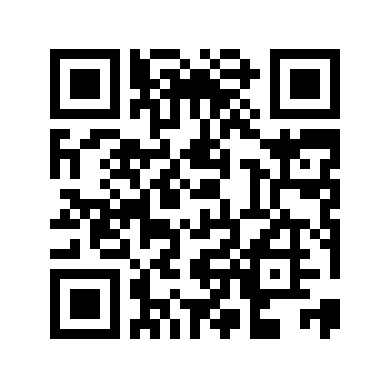

In [33]:
# from PIL import Image

# # Open and display the QR code
# img = Image.open("/content/product_qr.png")
import matplotlib.pyplot as plt
# from PIL import Image

# Open the image
img = Image.open("/content/bottle_3_product_qr.png")

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide the axis for a cleaner view
plt.show()

img.show()
